In [62]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


In [63]:

def simulate_falcon9_trajectory():
    # Constants
    g0 = 9.81  # Standard gravity (m/s²)
    Earth_radius = 6371e3  # Earth radius (m)
    
    # Falcon 9-like parameters (simplified)
    m0_stage1 = 450e3  # Initial mass (kg)
    mf_stage1 = 150e3   # Dry mass (kg)
    thrust_stage1 = 7.6e6  # Thrust (N)
    burn_time_stage1 = 162  # Burn time (s)
    Isp_stage1 = 282  # Specific impulse (s)
    
    # Stage 2 (simplified)
    thrust_stage2 = 934e3  # Thrust (N)
    Isp_stage2 = 348  # Specific impulse (s)
    burn_time_stage2 = 397  # Burn time (s)
    
    # Simulation parameters
    dt = 0.1  # Time step (s)
    gravity_turn_rate = 0.15  # Slower pitch change (degrees per second)
    time = np.arange(0, burn_time_stage1 + burn_time_stage2, dt)
    
    # Initialize arrays
    altitude = np.zeros_like(time)
    velocity = np.zeros_like(time)
    mass = np.zeros_like(time)
    thrust = np.zeros_like(time)
    
    # Phase flags
    gravity_turn_start = 10  # Start gravity turn at 10s
    stage_separation = burn_time_stage1
    
    # Initial conditions
    mass[0] = m0_stage1
    altitude[0] = 0.0
    velocity[0] = 0.0
    
    # Simulate ascent
    for i in range(1, len(time)):
        # Current thrust (stage 1 or 2)
        if time[i] < stage_separation:
            thrust[i] = thrust_stage1
            m_dot = thrust_stage1 / (Isp_stage1 * g0)  # Propellant mass flow rate (kg/s)
        else:
            thrust[i] = thrust_stage2
            m_dot = thrust_stage2 / (Isp_stage2 * g0)
        
        # Update mass
        mass[i] = mass[i-1] - m_dot * dt
        
        # Pitch control (gentler turn)
        if time[i] < gravity_turn_start:
            pitch = 90  # Vertical
        else:
            pitch = max(1.0, 90 - (time[i] - gravity_turn_start) * gravity_turn_rate)  # Prevents negative pitch
        
        pitch_rad = np.radians(pitch)
        
        # Acceleration (thrust - gravity - drag would go here)
        acceleration = (thrust[i] / mass[i]) - g0 * np.sin(pitch_rad)
        
        # Update velocity and altitude
        velocity[i] = velocity[i-1] + acceleration * dt
        altitude[i] = altitude[i-1] + velocity[i] * np.sin(pitch_rad) * dt # Ground clamp
        
    return time, altitude, velocity, thrust, stage_separation


In [64]:

# Run simulation
time, altitude, velocity, thrust, stage_sep = simulate_falcon9_trajectory()


In [65]:
#altitude = altitude / 1000  # Convert to km
altitude = np.clip(altitude, 0, None)  # Ensure no negative altitudes

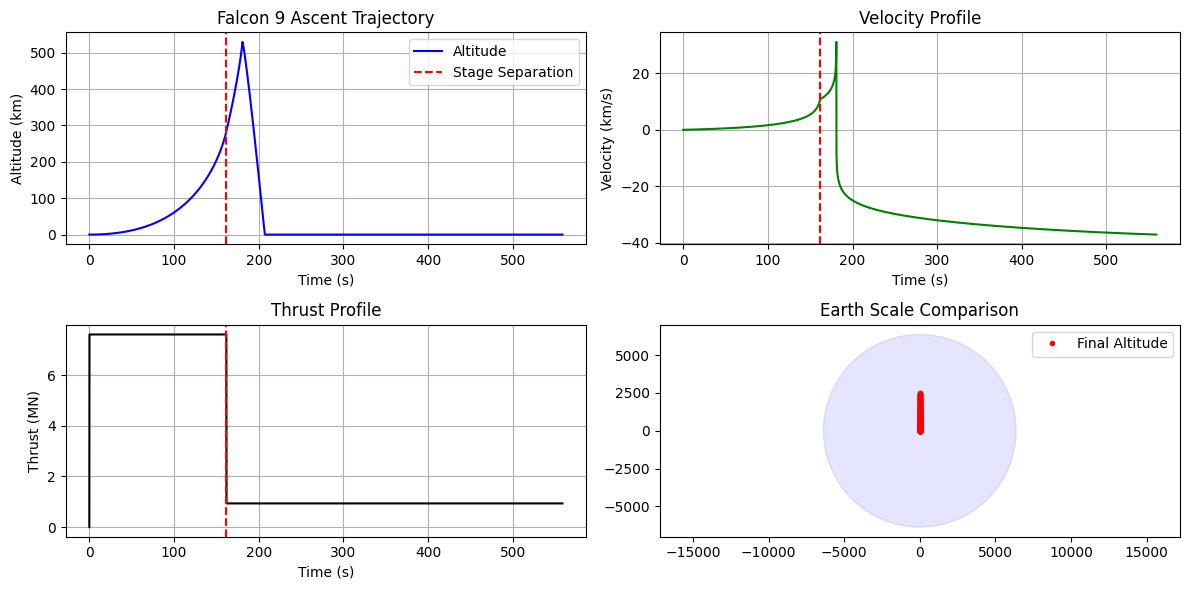

In [66]:

# Plot results
plt.figure(figsize=(12, 6))

# Trajectory
plt.subplot(2, 2, 1)
plt.plot(time, altitude / 1000, 'b-', label='Altitude')
plt.axvline(x=stage_sep, color='r', linestyle='--', label='Stage Separation')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (km)')
plt.title('Falcon 9 Ascent Trajectory')
plt.grid()
plt.legend()

# Velocity
plt.subplot(2, 2, 2)
plt.plot(time, velocity / 1000, 'g-')
plt.axvline(x=stage_sep, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (km/s)')
plt.title('Velocity Profile')
plt.grid()

# Thrust
plt.subplot(2, 2, 3)
plt.plot(time, thrust / 1e6, 'k-')
plt.axvline(x=stage_sep, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Thrust (MN)')
plt.title('Thrust Profile')
plt.grid()

# Earth for scale (simplified)
plt.subplot(2, 2, 4)
earth = Circle((0, 0), 6371, color='blue', alpha=0.1)
plt.gca().add_patch(earth)
plt.plot(time[:250]/100, altitude[:250], 'ro', markersize=3, label='Final Altitude')
plt.axis('equal')
plt.title('Earth Scale Comparison')
plt.legend()

plt.tight_layout()
plt.show()